In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the data
train_data = pd.read_csv('../input/ml-olympiad-gdscuiz-and-tfugagadir/train.csv',usecols=['genome_sequence','species'])
train_data = train_data.sample(n=500000)
species_counts = train_data['species'].value_counts(normalize=True)
print(species_counts)

species
Gorilla_gorilla    0.500042
Homo_sapiens       0.499958
Name: proportion, dtype: float64


In [3]:
# Build the model
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
                           input_shape=(9, 9, 4),
                           padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', 
                           padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', 
                           padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')  # Assuming 2 classes, adjust if necessary
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 64)          2368      
                                                                 
 batch_normalization (BatchN  (None, 9, 9, 64)         256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 5, 5, 64)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 batch_normalization_1 (Batc  (None, 5, 5, 128)        5

In [4]:
def preprocess_dataset(data, test=False):
    def one_hot_encode(sequence):
        mapping = {'a': [1, 0, 0, 0], 'c': [0, 1, 0, 0], 'g': [0, 0, 1, 0], 't': [0, 0, 0, 1]}
        return [mapping[char] for char in sequence]

    encoded_seqs = data['genome_sequence'].apply(one_hot_encode)
    padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded_seqs, padding='post')
    
    if not test:
        # Encode the species labels into numerical values
        label_encoder = LabelEncoder()
        encoded_labels = label_encoder.fit_transform(data['species'])
        encoded_labels = tf.keras.utils.to_categorical(encoded_labels, num_classes=2)
    
    num_samples = len(padded_seqs)
    reshaped_data = np.zeros((num_samples, 9, 9, 4))  # Initialize an empty array of the desired shape

    for i, sequence in enumerate(padded_seqs):
        # Reshape the sequence to a 2D 80x4 matrix
        sequence_2d = sequence.reshape(-1, 4)

        # Pad this matrix with a row of zeros to get a 81x4 matrix
        padded_sequence = np.vstack((sequence_2d, np.zeros((1, 4))))

        # Reshape this matrix to a 9x9x4 tensor
        reshaped_sequence = padded_sequence.reshape(9, 9, 4)

        # Store the reshaped sequence in the reshaped_data array
        reshaped_data[i] = reshaped_sequence
    if not test:
        return reshaped_data, encoded_labels
    else:
        return reshaped_data

In [5]:
x_train_data, y_train_data = preprocess_dataset(train_data)

In [6]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train_data, y_train_data, test_size=0.2, random_state=42)

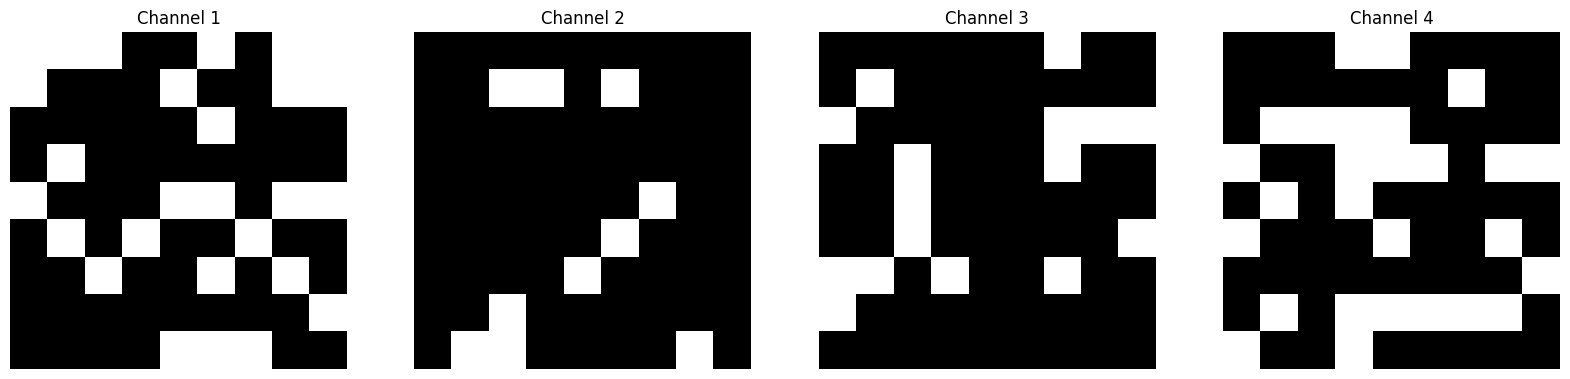

In [7]:
def plot_images(data_piece):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    
    # Assuming data_piece has shape (9, 9, 4)
    for i in range(4):
        img = data_piece[:, :, i]
        axs[i].imshow(img, cmap='gray')  # or choose a different colormap if preferred
        axs[i].axis('off')  # to remove the axes for clarity
        axs[i].set_title(f'Channel {i+1}')
    
    plt.show()
plot_images(x_train[0])

In [8]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define the Early Stopping and Reduce LR On Plateau callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)

In [9]:
# Train the model with the callbacks
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=25,
                    batch_size=128,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/25


2023-10-06 15:36:37.673959: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3125/3125 [==============================] - 29s 6ms/step - loss: 1.0012 - accuracy: 0.5022 - val_loss: 0.6931 - val_accuracy: 0.5006 - lr: 0.0010
Epoch 2/25
3125/3125 [==============================] - 22s 7ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.4994 - lr: 0.0010
Epoch 3/25
3125/3125 [==============================] - 18s 6ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.4994 - lr: 0.0010
Epoch 4/25
3119/3125 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5001
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
3125/3125 [==============================] - 18s 6ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.5006 - lr: 0.0010
Epoch 5/25
3125/3125 [==============================] - 18s 6ms/step - loss: 0.6931 - accuracy: 0.5012 - val_loss: 0.6931 - val_accuracy: 0.5006 - lr: 2.0000e-04
Epoch 6/25
3125/3125 [==============================]

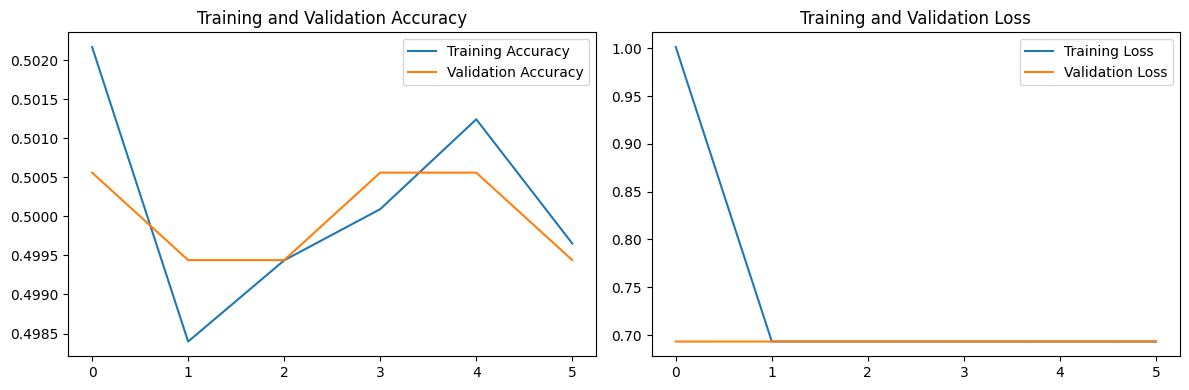

In [10]:
# Plotting the training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
test_data = pd.read_csv('../input/ml-olympiad-gdscuiz-and-tfugagadir/test.csv', usecols=['genome_sequence'])

x_test_data = preprocess_dataset(test_data, True)

# Make predictions
predictions = model.predict(x_test_data)
predicted_labels = np.argmax(predictions, axis=1)  # assuming a multi-class classification problem
di = {
    0: "Homo_sapiens",
    1: "Gorilla_gorilla"
}
predicted_labels = [v for v in predicted_labels]

6250/6250 [==============================] - 12s 2ms/step


In [12]:
np.unique(predicted_labels, return_counts=True)

(array([0]), array([200000]))

In [13]:
# Create submission DataFrame
submission_df = pd.DataFrame({'id': test_data.index, 'species': predicted_labels})

# Save to CSV
submission_df.to_csv('submission.csv', index=False)